In [1]:
ls

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 702E-35B2

 c:\Users\Sejong\Desktop\hanhwa\model ���͸�

2023-11-28  ���� 11:18    <DIR>          .
2023-11-28  ���� 10:44    <DIR>          ..
2023-11-28  ���� 11:07                 0 __init__.py
2023-11-28  ���� 11:43    <DIR>          __pycache__
2023-11-27  ���� 02:52             8,532 LSTM_multi_step.ipynb
2023-11-28  ���� 10:45           154,599 LSTM_Single_Step.ipynb
2023-11-28  ���� 03:20            19,251 transformer_multistep_prediction.ipynb
2023-11-28  ���� 11:43            12,578 transformer_singlestep.py
2023-11-28  ���� 08:49           195,625 transformer_singlestep_prediction_11_24.ipynb
               6�� ����             390,585 ����Ʈ
               3�� ���͸�  389,469,708,288 ����Ʈ ����


In [2]:
cd ..

c:\Users\Sejong\Desktop\hanhwa


| epoch   1 |   207/ 1038 batches | lr 0.001000 | 20.17 ms | loss 0.67148 | ppl     1.96
| epoch   1 |   414/ 1038 batches | lr 0.001000 | 18.79 ms | loss 0.00481 | ppl     1.00
| epoch   1 |   621/ 1038 batches | lr 0.001000 | 18.72 ms | loss 0.00089 | ppl     1.00
| epoch   1 |   828/ 1038 batches | lr 0.001000 | 18.91 ms | loss 0.00084 | ppl     1.00
| epoch   1 |  1035/ 1038 batches | lr 0.001000 | 19.01 ms | loss 0.00634 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 22.12s | valid loss 0.33806 | valid ppl     1.40
-----------------------------------------------------------------------------------------
| epoch   2 |   207/ 1038 batches | lr 0.000960 | 18.92 ms | loss 0.03480 | ppl     1.04
| epoch   2 |   414/ 1038 batches | lr 0.000960 | 18.93 ms | loss 0.00240 | ppl     1.00
| epoch   2 |   621/ 1038 batches | lr 0.000960 | 18.88 ms | loss 0.00067 | ppl     1.00
| epoch   2 |   828/ 1038 batche

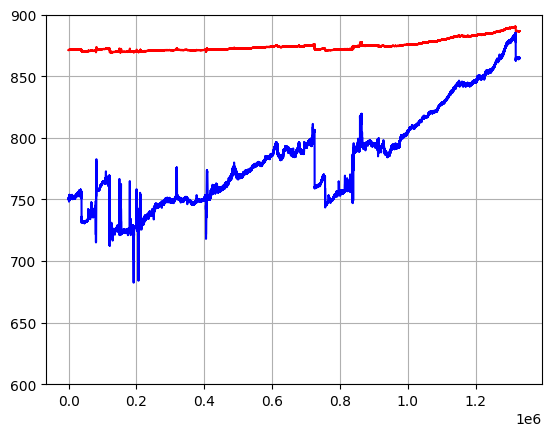

-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 223.57s | valid loss 0.23474 | valid ppl     1.26
-----------------------------------------------------------------------------------------
| epoch  21 |   207/ 1038 batches | lr 0.000654 | 20.36 ms | loss 0.04321 | ppl     1.04
| epoch  21 |   414/ 1038 batches | lr 0.000654 | 18.59 ms | loss 0.00048 | ppl     1.00
| epoch  21 |   621/ 1038 batches | lr 0.000654 | 19.57 ms | loss 0.00041 | ppl     1.00
| epoch  21 |   828/ 1038 batches | lr 0.000654 | 19.18 ms | loss 0.00056 | ppl     1.00
| epoch  21 |  1035/ 1038 batches | lr 0.000654 | 19.10 ms | loss 0.00073 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 22.30s | valid loss 0.21607 | valid ppl     1.24
-----------------------------------------------------------------------------------------
| epoch  22 |   207/ 1038 batches | lr 0.0

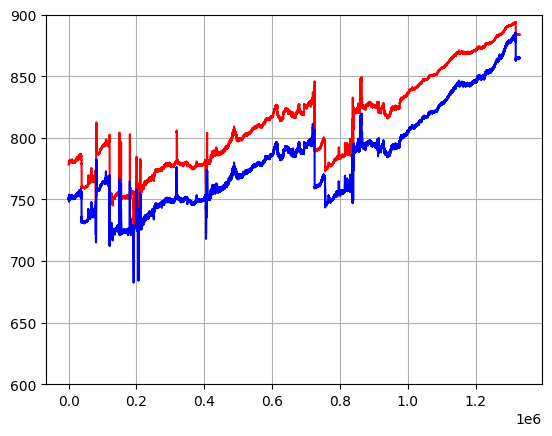

-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 302.61s | valid loss 0.02009 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  41 |   207/ 1038 batches | lr 0.000437 | 19.48 ms | loss 0.00097 | ppl     1.00
| epoch  41 |   414/ 1038 batches | lr 0.000437 | 18.78 ms | loss 0.00009 | ppl     1.00
| epoch  41 |   621/ 1038 batches | lr 0.000437 | 18.59 ms | loss 0.00007 | ppl     1.00
| epoch  41 |   828/ 1038 batches | lr 0.000437 | 18.70 ms | loss 0.00010 | ppl     1.00
| epoch  41 |  1035/ 1038 batches | lr 0.000437 | 19.28 ms | loss 0.00025 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 21.83s | valid loss 0.01815 | valid ppl     1.02
-----------------------------------------------------------------------------------------
| epoch  42 |   207/ 1038 batches | lr 0.0

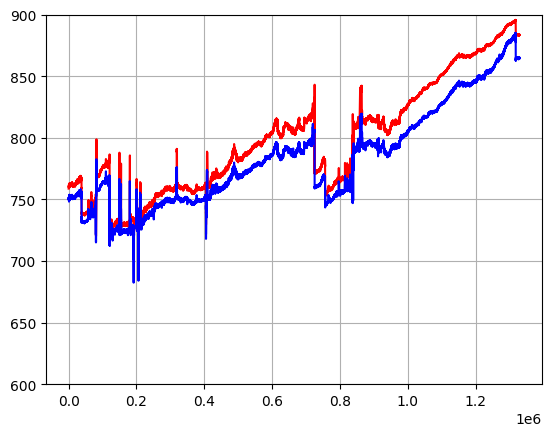

-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 221.07s | valid loss 0.00645 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  61 |   207/ 1038 batches | lr 0.000292 | 19.53 ms | loss 0.00039 | ppl     1.00
| epoch  61 |   414/ 1038 batches | lr 0.000292 | 18.74 ms | loss 0.00007 | ppl     1.00
| epoch  61 |   621/ 1038 batches | lr 0.000292 | 19.29 ms | loss 0.00006 | ppl     1.00
| epoch  61 |   828/ 1038 batches | lr 0.000292 | 18.74 ms | loss 0.00007 | ppl     1.00
| epoch  61 |  1035/ 1038 batches | lr 0.000292 | 18.75 ms | loss 0.00018 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  61 | time: 21.90s | valid loss 0.00601 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  62 |   207/ 1038 batches | lr 0.0

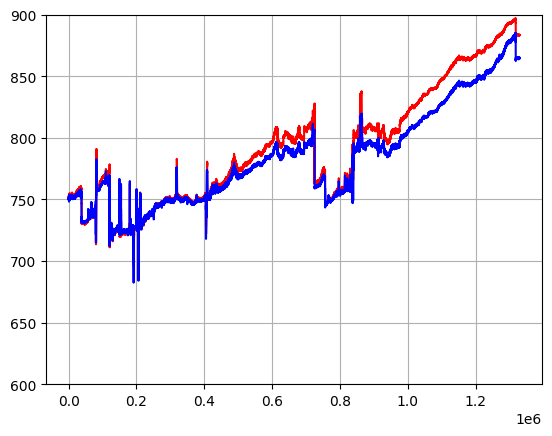

-----------------------------------------------------------------------------------------
| end of epoch  80 | time: 222.53s | valid loss 0.00325 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  81 |   207/ 1038 batches | lr 0.000195 | 19.27 ms | loss 0.00028 | ppl     1.00
| epoch  81 |   414/ 1038 batches | lr 0.000195 | 18.79 ms | loss 0.00007 | ppl     1.00
| epoch  81 |   621/ 1038 batches | lr 0.000195 | 18.85 ms | loss 0.00006 | ppl     1.00
| epoch  81 |   828/ 1038 batches | lr 0.000195 | 18.81 ms | loss 0.00005 | ppl     1.00
| epoch  81 |  1035/ 1038 batches | lr 0.000195 | 19.34 ms | loss 0.00013 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  81 | time: 21.90s | valid loss 0.00314 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch  82 |   207/ 1038 batches | lr 0.0

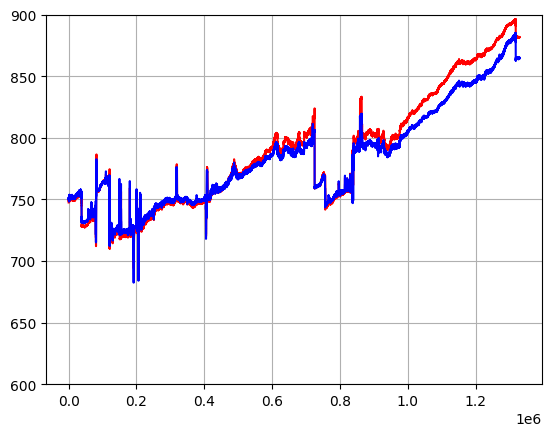

-----------------------------------------------------------------------------------------
| end of epoch 100 | time: 217.39s | valid loss 0.00200 | valid ppl     1.00
-----------------------------------------------------------------------------------------


In [6]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
input_window = 30
output_window = 10
batch_size = 512 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

from function_file.ML_functions import make_dataframe


def get_data():
    time        = np.arange(0, 400, 0.1) # 4000 sample
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    #amplitude = scaler.fit_transform(df.reshape(-1, 1)).reshape(-1)
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    _, df = make_dataframe(60,20)
    df = df['TEMP'].values   
    
    train_len = int(len(df) * 0.8)
    train_data = df[:train_len] 
    test_data = df[train_len:] 
    train_data = scaler_train.fit_transform(train_data.reshape(-1,1)).reshape(-1)
    test_data = scaler_test.fit_transform(test_data.reshape(-1,1)).reshape(-1)

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-output_window:].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-output_window:].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()

    test_result = scaler_test.inverse_transform(test_result.reshape(-1,1)).reshape(-1)
    truth = scaler_test.inverse_transform(truth.reshape(-1,1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth,color="blue")
    #pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.ylim([600,900])
    pyplot.show()
    pyplot.close()
    
    return test_result, truth, total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _  = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data = scaler_test.inverse_transform(data.reshape(-1,1)).reshape(-1)

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.show()
    pyplot.close()
        
# There is either an error in the loss or in the train method, but the results are different
# also to those of the predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 512
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

train_data, val_data = get_data()
model = TransAm().to(device)
from function_file.ML_functions import make_dataframe
criterion = nn.MSELoss()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if (epoch % 20 == 0):
        # epoch = 5 일 때마다 val_loss를 구하고, predict_future를 그린다.
        test_result, truth, val_loss = plot_and_loss(model, val_data)
        #predict_future(model, val_data,200)
    else:
        # epoch = 5의 배수가 아닐때마다는 evalute를 사용
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number) 
#out = model(src)
#
#print(out)
#print(out.shape)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

print("r2 : ", r2_score(truth, test_result))
print("MAE : ", mean_absolute_error(truth, test_result))
print("RMSE : ", mean_squared_error(truth, test_result)**0.5)

r2 :  0.9495403624764921
MAE :  6.884691874525865
RMSE :  9.072923252313494
